# MIDAS Heart/Resp Motion Pipeline

This notebook separates respiratory and cardiac motion, detects beats, and builds
time-series features for grouping into four conditions (control, doxo, doxo+epa, other).


## 0) Setup

We use the video frame rate as the sampling rate for time-series analysis.
At 60 fps, each beat has only ~3-4 samples for a 270-310 bpm heart rate.
This limits beat-shape fidelity and makes morphology comparisons unreliable.

Respiration is controlled; set RESP_BPM_RANGE to lock a narrow resp band.


## Saved figures
All plots are saved to `../outputs/figures/` as PNGs for later review.


## Sampling limitations limitations

At 60 fps and 270-310 bpm, each beat has ~11-13 samples.
This is better for beat-shape clustering, but morphology detail is still moderate.
We keep those sections for reference, but record-level features remain stable, and beat-level shape is more feasible at 60 fps.


In [129]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from scipy.signal import butter, sosfiltfilt, welch, find_peaks, hilbert
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

try:
    from sktime.transformations.panel.rocket import MiniRocket
except Exception:
    MiniRocket = None

try:
    import hdbscan
except Exception:
    hdbscan = None

try:
    from umap import UMAP
except Exception:
    UMAP = None

try:
    from tslearn.clustering import KShape
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
except Exception:
    KShape = None
    TimeSeriesScalerMeanVariance = None


In [130]:
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("../outputs")
FIG_DIR = OUTPUT_DIR / "figures"
FIG_DPI = 150
FRAME_RATE_FPS = 60.0
USE_FRAME_RATE = True
RESP_BPM_RANGE = (70.0, 80.0)
RESP_BAND_HZ = (0.1, 2.0)
MIN_BPM = 270
MAX_BPM = 310
HEART_BAND_HZ = (MIN_BPM / 60.0, MAX_BPM / 60.0)
SEPARATION_METHOD = "filter"  # fft or filter
REFRACTORY_S = 0.85 * (60.0 / MAX_BPM)
BEAT_WINDOW_S = (0.3 * (60.0 / MIN_BPM), 0.7 * (60.0 / MIN_BPM))
ENV_SMOOTH_S = 0.05
RESP_MIN_PERIOD_S = 0.5
RESP_SMOOTH_S = 0.3
RESP_PROMINENCE_FACTOR = 1.0
RESAMPLE_LEN = 256


In [131]:
def save_fig(name: str) -> None:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / name, dpi=FIG_DPI, bbox_inches="tight")


In [132]:
def resp_band_from_target() -> tuple[float, float]:
    if RESP_BPM_RANGE is None:
        return RESP_BAND_HZ
    low_bpm, high_bpm = RESP_BPM_RANGE
    return (max(0.01, low_bpm / 60.0), high_bpm / 60.0)


## Expected heart rate range

Targeting 270-310 bpm (~4.5-5.2 Hz). We set a tight heart band and
derive refractory period and beat window sizes from this range.



## 1) Load data and estimate sampling rate

If `USE_FRAME_RATE` is enabled, the time column is ignored and time is reconstructed
from the constant frame rate. This avoids mislabeled or inconsistent timestamps.


In [133]:
@dataclass
class Record:
    path: Path
    label: str
    time_s: np.ndarray
    signal: np.ndarray
    fs: float
    group_id: str


def label_from_name(name: str) -> str:
    lower = name.lower()
    if lower.startswith("control"):
        return "control"
    if lower.startswith("doxo"):
        return "doxo"
    if lower.startswith("empa_doxo") or lower.startswith("preconditionare_empa_doxo"):
        return "empa_doxo"
    if lower.startswith("empa"):
        return "empa"
    return "other"


def load_records(data_dir: Path) -> list[Record]:
    records: list[Record] = []
    for path in sorted(data_dir.glob("*.csv")):
        df = pd.read_csv(path)
        signal = df.iloc[:, 1].to_numpy(dtype=float)
        if USE_FRAME_RATE:
            fs = FRAME_RATE_FPS
            time_s = np.arange(len(signal)) / fs
        else:
            time_s = df.iloc[:, 0].to_numpy(dtype=float)
            dt = np.diff(time_s)
            fs = 1.0 / float(np.median(dt)) if len(dt) else 0.0
        records.append(
            Record(
                path=path,
                label=label_from_name(path.stem),
                time_s=time_s,
                signal=signal,
                fs=fs,
                group_id=path.stem,
            )
        )
    return records


records = load_records(DATA_DIR)
{rec.path.name: rec.fs for rec in records}


{'control(I.1).csv': 60.0,
 'control(I.2).csv': 60.0,
 'control(I.3).csv': 60.0,
 'control(I.4).csv': 60.0,
 'doxo(IV.1).csv': 60.0,
 'doxo(IV.1)_2.csv': 60.0,
 'doxo(IV.2).csv': 60.0,
 'doxo_re(IV.3).csv': 60.0,
 'doxo_re(IV.4).csv': 60.0,
 'empa(II.1).csv': 60.0,
 'empa(II.2).csv': 60.0,
 'empa(II.3).csv': 60.0,
 'empa_doxo(III.1).csv': 60.0,
 'empa_doxo(III.2).csv': 60.0,
 'empa_doxo(III.3).csv': 60.0,
 'preconditionare_empa_doxo(V.1).csv': 60.0,
 'preconditionare_empa_doxo(V.2).csv': 60.0,
 'preconditionare_empa_doxo(V.3).csv': 60.0}

## 2) Spectrum inspection (Welch PSD)

Use PSD to confirm the heart-band peak is present and separated from respiration.
At low sampling rates, the heart band sits near Nyquist and can be noisy.


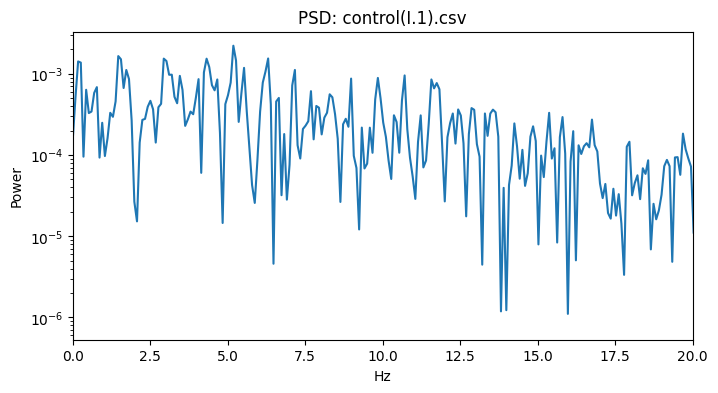

In [134]:
rec = records[0]
f, pxx = welch(rec.signal, fs=rec.fs, nperseg=min(2048, len(rec.signal)))
plt.figure(figsize=(8, 4))
plt.semilogy(f, pxx)
plt.title(f"PSD: {rec.path.name}")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.xlim(0, 20)
save_fig(f"psd_{rec.path.stem}.png")
plt.show()


## 2c) Rough HR estimation via PSD peak
At 60 fps, beat shapes are under-sampled, but the PSD peak can still provide
a rough heart-rate estimate. This uses frequency-domain energy only.


## 2b) Fourier decomposition (FFT masking)

FFT masking provides a quick split, but can introduce ringing and boundary artifacts.
Compare with filter-based separation if results look distorted.


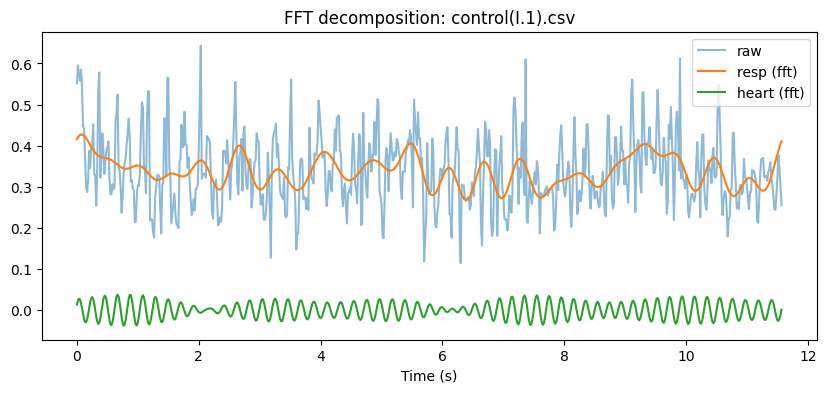

In [135]:
def fft_bandpass(signal: np.ndarray, fs: float, band: tuple[float, float]) -> np.ndarray:
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1.0 / fs)
    fft_vals = np.fft.rfft(signal)
    low, high = band
    mask = (freqs >= low) & (freqs <= high)
    filtered_fft = np.where(mask, fft_vals, 0)
    return np.fft.irfft(filtered_fft, n=n)


rec = records[0]
resp_fft = fft_bandpass(rec.signal, rec.fs, (0.0, RESP_BAND_HZ[1]))
heart_fft = fft_bandpass(rec.signal, rec.fs, HEART_BAND_HZ)
plt.figure(figsize=(10, 4))
plt.plot(rec.time_s, rec.signal, label="raw", alpha=0.5)
plt.plot(rec.time_s, resp_fft, label="resp (fft)")
plt.plot(rec.time_s, heart_fft, label="heart (fft)")
plt.legend()
plt.title(f"FFT decomposition: {rec.path.name}")
plt.xlabel("Time (s)")
save_fig(f"fft_decomposition_{rec.path.stem}.png")
plt.show()


## 3) Separate respiration and heart (zero-phase filtering)

Zero-phase filters reduce timing shifts, which is critical for beat detection.
With low fps, keep the band narrow and avoid aggressive filtering.


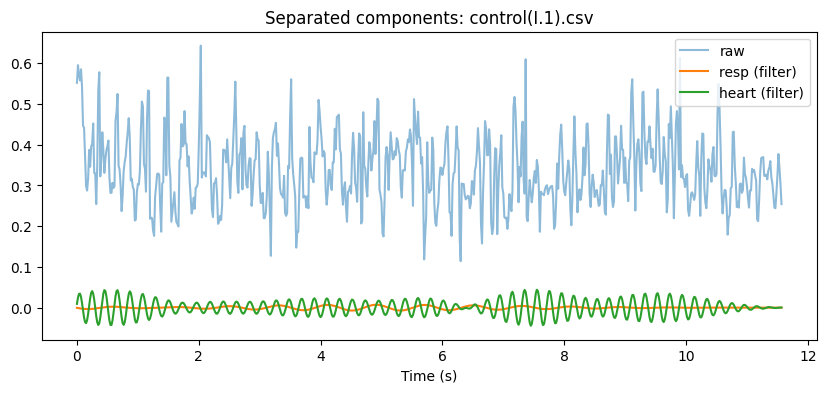

In [136]:
def band_limits(band: tuple[float, float], fs: float) -> tuple[float, float]:
    low, high = band
    nyq = fs / 2.0
    return (max(0.01, low), min(high, 0.95 * nyq))


def butter_sos(band: tuple[float, float], fs: float, order: int = 4) -> np.ndarray:
    low, high = band_limits(band, fs)
    return butter(order, [low, high], btype="bandpass", fs=fs, output="sos")


def lowpass_sos(cutoff: float, fs: float, order: int = 4) -> np.ndarray:
    cutoff = min(cutoff, 0.95 * (fs / 2.0))
    return butter(order, cutoff, btype="lowpass", fs=fs, output="sos")


def fft_bandpass(signal: np.ndarray, fs: float, band: tuple[float, float]) -> np.ndarray:
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1.0 / fs)
    fft_vals = np.fft.rfft(signal)
    low, high = band
    mask = (freqs >= low) & (freqs <= high)
    filtered_fft = np.where(mask, fft_vals, 0)
    return np.fft.irfft(filtered_fft, n=n)


def separate_components(signal: np.ndarray, fs: float, method: str = "filter") -> tuple[np.ndarray, np.ndarray]:
    if method == "fft":
        resp_band = resp_band_from_target()
        resp = fft_bandpass(signal, fs, resp_band)
        heart = fft_bandpass(signal, fs, HEART_BAND_HZ)
    else:
        resp_band = resp_band_from_target()
        resp_sos = butter_sos(resp_band, fs)
        heart_sos = butter_sos(HEART_BAND_HZ, fs)
        resp = sosfiltfilt(resp_sos, signal)
        heart = sosfiltfilt(heart_sos, signal)
    return resp, heart


rec = records[0]
resp, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
plt.figure(figsize=(10, 4))
plt.plot(rec.time_s, rec.signal, label="raw", alpha=0.5)
plt.plot(rec.time_s, resp, label=f"resp ({SEPARATION_METHOD})")
plt.plot(rec.time_s, heart, label=f"heart ({SEPARATION_METHOD})")
plt.legend()
plt.title(f"Separated components: {rec.path.name}")
plt.xlabel("Time (s)")
save_fig(f"separation_{SEPARATION_METHOD}_{rec.path.stem}.png")
plt.show()


In [137]:
def estimate_hr_psd(signal: np.ndarray, fs: float, band: tuple[float, float], method: str) -> float | None:
    _, heart = separate_components(signal, fs, method=method)
    f, pxx = welch(heart, fs=fs, nperseg=min(2048, len(heart)))
    low, high = band
    mask = (f >= low) & (f <= high)
    if not np.any(mask):
        return None
    idx = np.argmax(pxx[mask])
    peak_hz = f[mask][idx]
    return 60.0 * peak_hz


hr_psd = []
for rec in records:
    hr = estimate_hr_psd(rec.signal, rec.fs, HEART_BAND_HZ, SEPARATION_METHOD)
    hr_psd.append(hr)

print("PSD HR (bpm):", [round(h, 1) if h else None for h in hr_psd])
if any(h is not None for h in hr_psd):
    arr = np.array([h for h in hr_psd if h is not None])
    print(f"PSD HR summary: mean={arr.mean():.1f}, median={np.median(arr):.1f}, min={arr.min():.1f}, max={arr.max():.1f}")


PSD HR (bpm): [279.7, 284.2, 273.5, 280.2, 297.0, 304.2, 274.3, 290.7, 289.5, 307.9, 273.6, 281.7, 288.6, 296.4, 292.3, 276.9, 275.9, 281.7]
PSD HR summary: mean=286.0, median=283.0, min=273.5, max=307.9


## 3b) Decomposition plots by category

We plot one representative file per category to compare component separation.
If components look similar across categories, clustering will be difficult.


## 3c) Respiratory cycle timing (full cycle + inhale/exhale)
We estimate respiration cycle durations from the low-frequency component.
At 60 fps this is reliable because respiration is slow and periodic.


In [138]:
def smooth_signal(signal: np.ndarray, fs: float, window_s: float) -> np.ndarray:
    window = max(1, int(window_s * fs))
    if window <= 1:
        return signal
    kernel = np.ones(window) / window
    return np.convolve(signal, kernel, mode="same")


def analyze_resp_cycles(resp: np.ndarray, fs: float) -> dict:
    resp_smoothed = smooth_signal(resp, fs, RESP_SMOOTH_S)
    resp_min_period_s = RESP_MIN_PERIOD_S
    if RESP_BPM_RANGE is not None:
        resp_min_period_s = 0.7 * (60.0 / max(RESP_BPM_RANGE))
    distance = max(1, int(resp_min_period_s * fs))
    median = np.median(resp_smoothed)
    mad = np.median(np.abs(resp_smoothed - median)) + 1e-9
    prominence = mad * RESP_PROMINENCE_FACTOR

    peaks, _ = find_peaks(resp_smoothed, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-resp_smoothed, distance=distance, prominence=prominence)

    peaks_t = peaks / fs
    troughs_t = troughs / fs

    full_cycles = np.diff(peaks_t).tolist() if len(peaks_t) > 1 else []
    inhalations = []
    exhalations = []

    for peak_t in peaks_t:
        prev_troughs = troughs_t[troughs_t < peak_t]
        next_troughs = troughs_t[troughs_t > peak_t]
        if len(prev_troughs) > 0:
            inhalations.append(float(peak_t - prev_troughs[-1]))
        if len(next_troughs) > 0:
            exhalations.append(float(next_troughs[0] - peak_t))

    return {
        "resp_smoothed": resp_smoothed,
        "peaks": peaks,
        "troughs": troughs,
        "full_cycle_s": full_cycles,
        "inhalation_s": inhalations,
        "exhalation_s": exhalations,
    }


for rec in records:
    resp, _ = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
    metrics = analyze_resp_cycles(resp, rec.fs)
    full_cycle = metrics["full_cycle_s"]
    inhale = metrics["inhalation_s"]
    exhale = metrics["exhalation_s"]
    if full_cycle:
        print(f"{rec.path.name} full cycle: mean={np.mean(full_cycle):.2f}s, median={np.median(full_cycle):.2f}s")
        if RESP_BPM_RANGE is not None:
            expected_period = 60.0 / (sum(RESP_BPM_RANGE) / 2.0)
            delta = np.mean(full_cycle) - expected_period
            print(f"{rec.path.name} cycle delta vs expected: {delta:+.2f}s")
    if inhale:
        print(f"{rec.path.name} inhalation: mean={np.mean(inhale):.2f}s, median={np.median(inhale):.2f}s")
    if exhale:
        print(f"{rec.path.name} exhalation: mean={np.mean(exhale):.2f}s, median={np.median(exhale):.2f}s")



control(I.1).csv full cycle: mean=0.83s, median=0.80s
control(I.1).csv cycle delta vs expected: +0.03s
control(I.1).csv inhalation: mean=0.42s, median=0.40s
control(I.1).csv exhalation: mean=0.41s, median=0.40s
control(I.2).csv full cycle: mean=0.79s, median=0.78s
control(I.2).csv cycle delta vs expected: -0.01s
control(I.2).csv inhalation: mean=0.40s, median=0.40s
control(I.2).csv exhalation: mean=0.39s, median=0.40s
control(I.3).csv full cycle: mean=0.79s, median=0.80s
control(I.3).csv cycle delta vs expected: -0.01s
control(I.3).csv inhalation: mean=0.40s, median=0.40s
control(I.3).csv exhalation: mean=0.40s, median=0.40s
control(I.4).csv full cycle: mean=0.79s, median=0.78s
control(I.4).csv cycle delta vs expected: -0.01s
control(I.4).csv inhalation: mean=0.39s, median=0.40s
control(I.4).csv exhalation: mean=0.39s, median=0.40s
doxo(IV.1).csv full cycle: mean=0.80s, median=0.80s
doxo(IV.1).csv cycle delta vs expected: -0.00s
doxo(IV.1).csv inhalation: mean=0.40s, median=0.40s
doxo(

## 3d) Respiratory cycle visualization by category
Plots the smoothed respiratory signal with detected peaks and troughs.


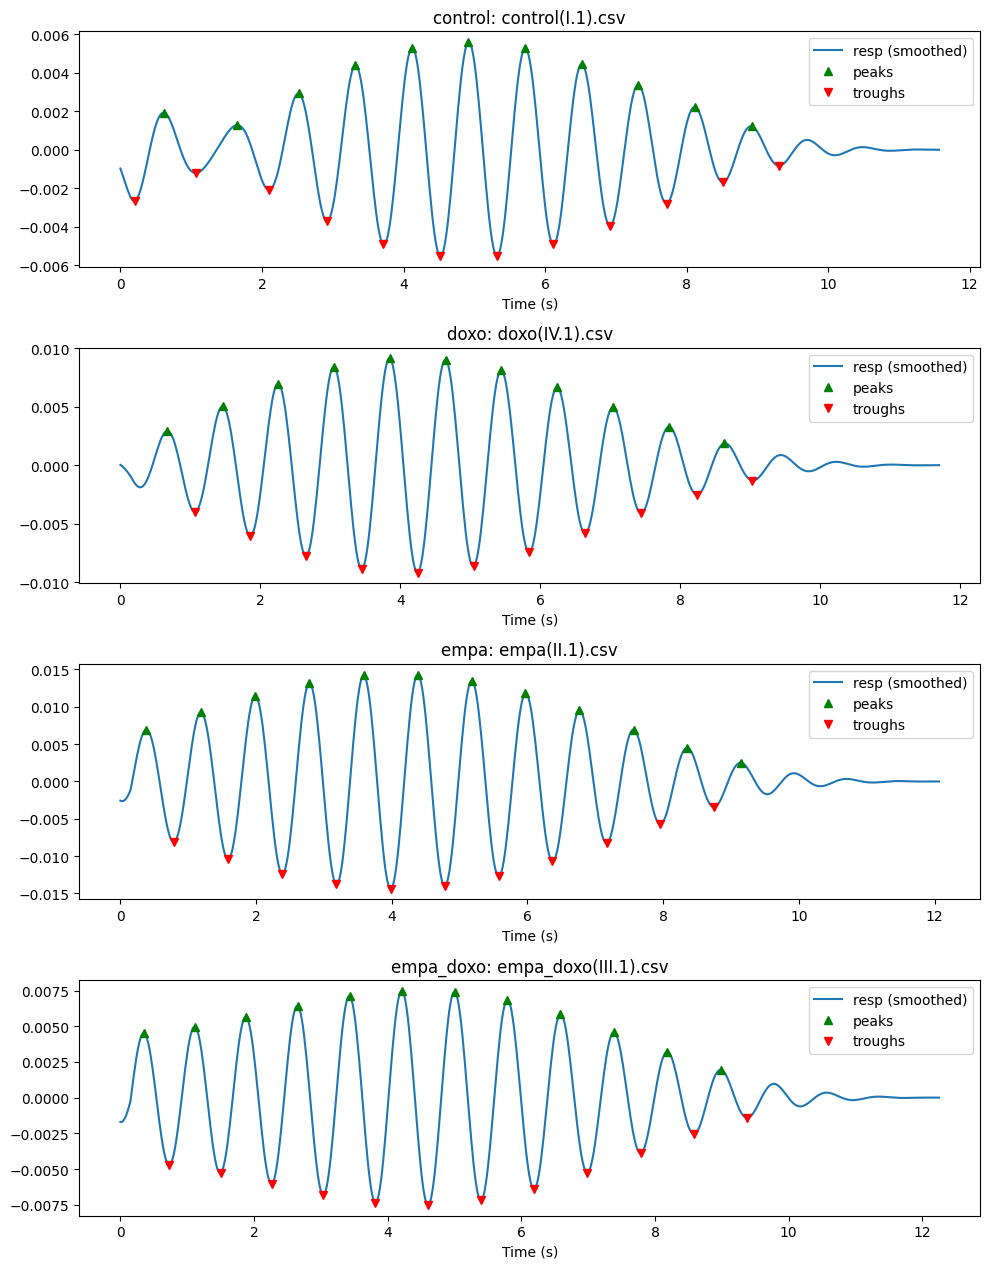

In [139]:
def plot_resp_cycles_by_category(records: list[Record], method: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 1, figsize=(10, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for ax, label in zip(axes, labels):
        rec = grouped[label][0]
        resp, _ = separate_components(rec.signal, rec.fs, method=method)
        metrics = analyze_resp_cycles(resp, rec.fs)
        resp_smoothed = metrics["resp_smoothed"]
        ax.plot(rec.time_s, resp_smoothed, label="resp (smoothed)")
        ax.plot(rec.time_s[metrics["peaks"]], resp_smoothed[metrics["peaks"]], "g^", label="peaks")
        ax.plot(rec.time_s[metrics["troughs"]], resp_smoothed[metrics["troughs"]], "rv", label="troughs")
        ax.set_title(f"{label}: {rec.path.name}")
        ax.set_xlabel("Time (s)")
        ax.legend()

    plt.tight_layout()
    save_fig(f"resp_cycles_by_category_{method}.png")
    plt.show()


plot_resp_cycles_by_category(records, SEPARATION_METHOD)


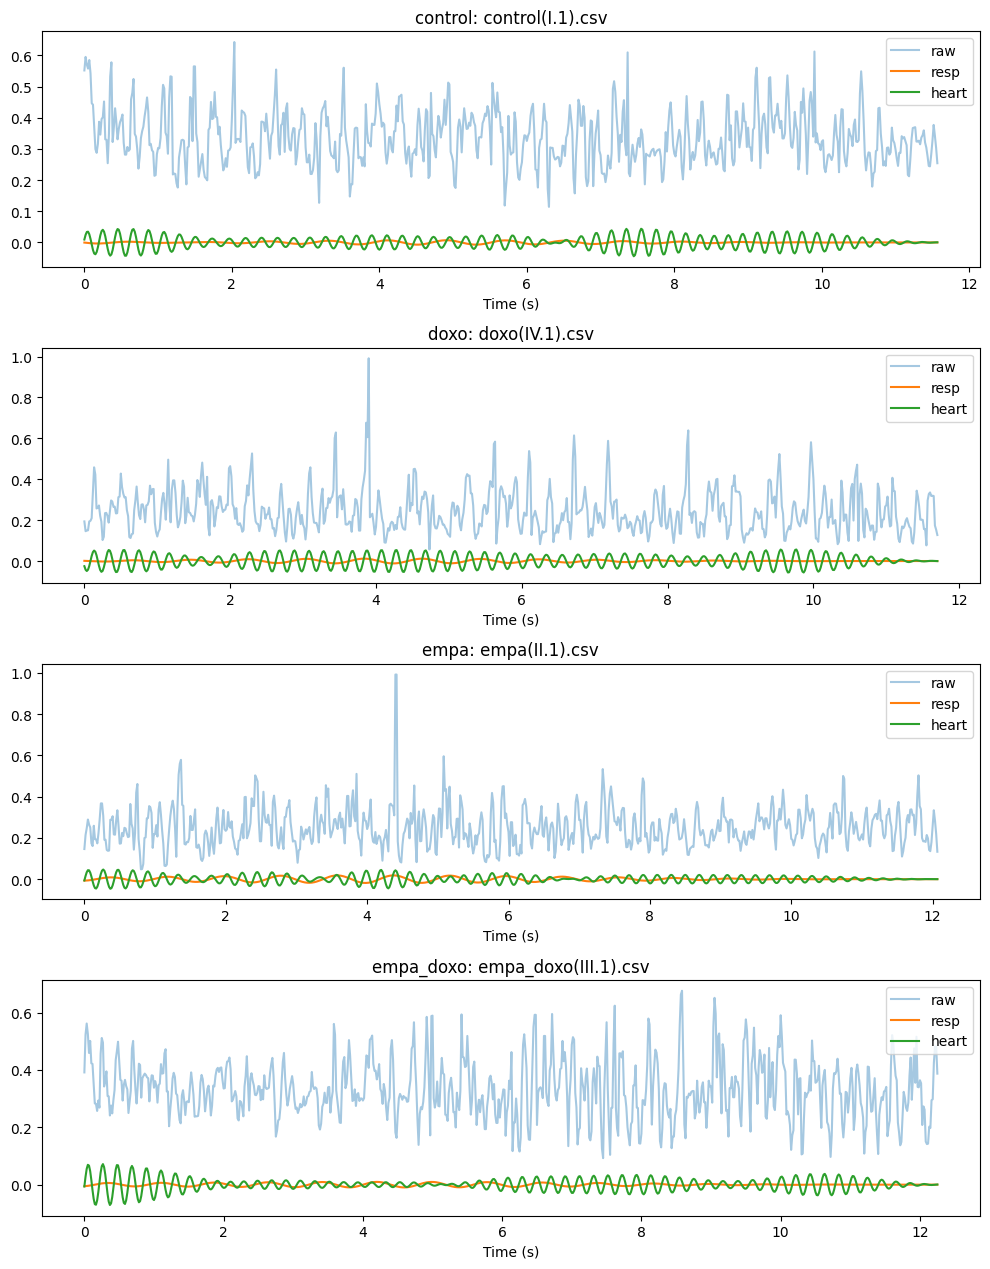

In [140]:
def plot_category_decomposition(records: list[Record], method: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 1, figsize=(10, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for ax, label in zip(axes, labels):
        rec = grouped[label][0]
        resp, heart = separate_components(rec.signal, rec.fs, method=method)
        ax.plot(rec.time_s, rec.signal, label="raw", alpha=0.4)
        ax.plot(rec.time_s, resp, label="resp")
        ax.plot(rec.time_s, heart, label="heart")
        ax.set_title(f"{label}: {rec.path.name}")
        ax.set_xlabel("Time (s)")
        ax.legend()

    plt.tight_layout()
    save_fig(f"decomposition_by_category_{method}.png")
plt.show()


plot_category_decomposition(records, SEPARATION_METHOD)


## 4) Beat detection on heart component

Beat picking uses the heart-band envelope with a refractory period and robust prominence.
At 60 fps, beat timing is adequate for HR estimation and basic morphology.


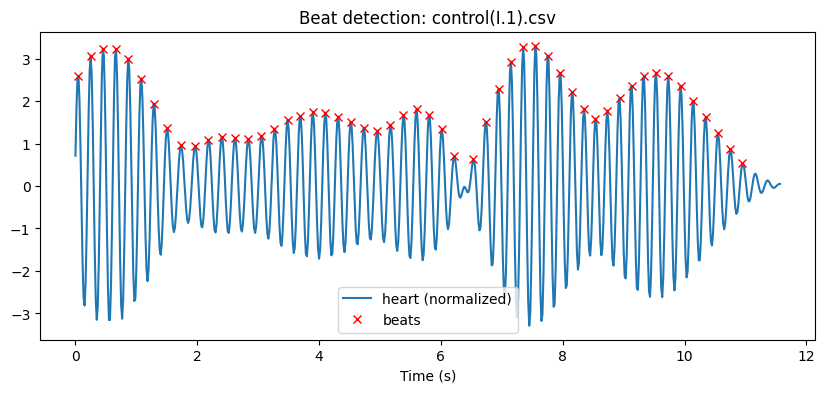

In [141]:
def heart_envelope(heart: np.ndarray, fs: float) -> np.ndarray:
    env = np.abs(hilbert(heart))
    window = max(1, int(ENV_SMOOTH_S * fs))
    if window > 1:
        kernel = np.ones(window) / window
        env = np.convolve(env, kernel, mode="same")
    return env


def detect_beats(heart: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    median = np.median(heart)
    mad = np.median(np.abs(heart - median)) + 1e-9
    heart_norm = (heart - median) / mad
    distance = max(1, int(0.6 * (60.0 / MAX_BPM) * fs))
    peaks, _ = find_peaks(heart_norm, distance=distance, prominence=0.5, height=0.5)
    return peaks, heart_norm


rec = records[0]
_, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
peaks, heart_norm = detect_beats(heart, rec.fs)
plt.figure(figsize=(10, 4))
plt.plot(rec.time_s, heart_norm, label="heart (normalized)")
plt.plot(rec.time_s[peaks], heart_norm[peaks], "rx", label="beats")
plt.legend()
plt.title(f"Beat detection: {rec.path.name}")
plt.xlabel("Time (s)")
save_fig(f"beat_detection_{rec.path.stem}.png")
plt.show()


## 4b) Beat detection visualization by category

These plots show envelope peaks for one file per category.
Check for consistent peak spacing and absence of respiratory leakage.


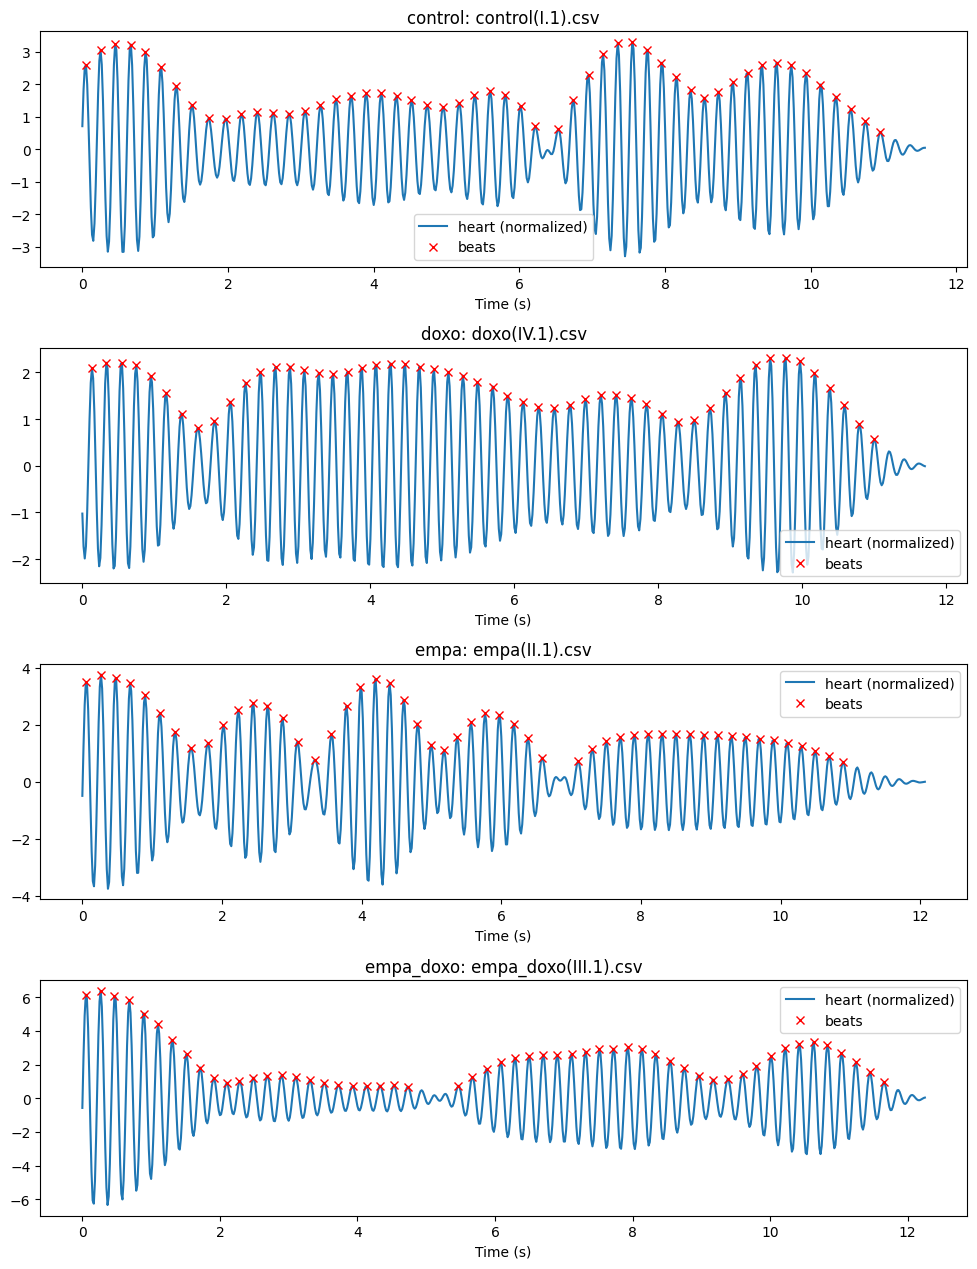

In [142]:
def plot_category_beats(records: list[Record], method: str) -> None:
    grouped: dict[str, list[Record]] = {}
    for rec in records:
        grouped.setdefault(rec.label, []).append(rec)

    labels = sorted(grouped.keys())
    fig, axes = plt.subplots(len(labels), 1, figsize=(10, 3.2 * len(labels)))
    if len(labels) == 1:
        axes = [axes]

    for ax, label in zip(axes, labels):
        rec = grouped[label][0]
        _, heart = separate_components(rec.signal, rec.fs, method=method)
        peaks, heart_norm = detect_beats(heart, rec.fs)
        ax.plot(rec.time_s, heart_norm, label="heart (normalized)")
        ax.plot(rec.time_s[peaks], heart_norm[peaks], "rx", label="beats")
        ax.set_title(f"{label}: {rec.path.name}")
        ax.set_xlabel("Time (s)")
        ax.legend()

    plt.tight_layout()
    save_fig(f"beat_detection_by_category_{method}.png")
    plt.show()


plot_category_beats(records, SEPARATION_METHOD)


## 4c) HR estimate from detected beats
Cross-check BPM from envelope peaks (median inter-beat interval).


In [143]:
def estimate_hr_peaks(signal: np.ndarray, fs: float) -> float | None:
    _, heart = separate_components(signal, fs, method=SEPARATION_METHOD)
    peaks, _ = detect_beats(heart, fs)
    if len(peaks) < 2:
        return None
    intervals = np.diff(peaks) / fs
    return 60.0 / float(np.median(intervals))


hr_peaks = []
for rec in records:
    hr = estimate_hr_peaks(rec.signal, rec.fs)
    hr_peaks.append(hr)

print("Peak HR (bpm):", [round(h, 1) if h else None for h in hr_peaks])
if any(h is not None for h in hr_peaks):
    arr = np.array([h for h in hr_peaks if h is not None])
    print(f"Peak HR summary: mean={arr.mean():.1f}, median={np.median(arr):.1f}, min={arr.min():.1f}, max={arr.max():.1f}")


Peak HR (bpm): [300.0, 300.0, 300.0, 276.9, 288.0, 300.0, 276.9, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 276.9, 300.0, 276.9, 276.9, 276.9]
Peak HR summary: mean=291.6, median=300.0, min=276.9, max=300.0


## 5) Extract beat windows (fixed length)

Beat windows are resampled to a fixed length for feature extraction.
At 60 fps, windows contain very few raw samples, limiting shape fidelity.


In [144]:
def extract_beat_windows(
    signal: np.ndarray,
    peaks: np.ndarray,
    fs: float,
    window_s: tuple[float, float],
    resample_len: int,
) -> list[np.ndarray]:
    pre_s, post_s = window_s
    pre = int(pre_s * fs)
    post = int(post_s * fs)
    windows: list[np.ndarray] = []
    for peak in peaks:
        start = peak - pre
        end = peak + post
        if start < 0 or end >= len(signal):
            continue
        snippet = signal[start:end]
        x_old = np.linspace(0.0, 1.0, num=len(snippet), endpoint=False)
        x_new = np.linspace(0.0, 1.0, num=resample_len, endpoint=False)
        windows.append(np.interp(x_new, x_old, snippet))
    return windows


beat_windows = extract_beat_windows(heart, peaks, rec.fs, BEAT_WINDOW_S, RESAMPLE_LEN)
len(beat_windows)


52

## Ground-truth groups (from filenames)

Labels are derived from filename prefixes only and are used **only** for evaluation. Clustering models do not see these labels during fitting. The four target groups are:

- control
- doxo (including doxo_re)
- empa
- empa_doxo (including preconditionare_empa_doxo)



## 6) Build dataset (beats -> features -> grouping)

We build beat-level samples and labels for evaluation only.
Clustering is unsupervised; labels are used strictly for post-hoc metrics.


In [145]:
beats: list[np.ndarray] = []
labels: list[str] = []
groups: list[str] = []

for rec in records:
    _, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
    peaks, _ = detect_beats(heart, rec.fs)
    windows = extract_beat_windows(heart, peaks, rec.fs, BEAT_WINDOW_S, RESAMPLE_LEN)
    beats.extend(windows)
    labels.extend([rec.label] * len(windows))
    groups.extend([rec.group_id] * len(windows))

X = np.stack(beats) if beats else np.empty((0, RESAMPLE_LEN))
y = np.array(labels)
group_ids = np.array(groups)
X.shape


(873, 256)

## 7) MiniROCKET baseline (supervised)

This is a supervised baseline to gauge separability. It is not used for clustering.
Low accuracy suggests limited signal at beat level.


In [146]:
if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    rocket = MiniRocket()
    X_feat = rocket.fit_transform(X3d)
    if hasattr(X_feat, "to_numpy"):
        X_feat = X_feat.to_numpy()
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7))
    unique_groups = np.unique(group_ids)
    if len(unique_groups) >= 3:
        splits = GroupKFold(n_splits=min(5, len(unique_groups))).split(X_feat, y, group_ids)
        scores = cross_val_score(clf, X_feat, y, cv=splits)
        print(f"Group CV accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")
    else:
        clf.fit(X_feat, y)
        print("Trained on full data (insufficient groups for CV).")


Group CV accuracy: 0.197 +/- 0.089


## 8) Clustering options (exploratory)

Clustering uses beat-level features without labels; metrics are computed after fitting.
At 60 fps, expect weak separation because beats are under-sampled.


In [147]:
def evaluate_clustering(y_true: np.ndarray, y_pred: np.ndarray, label: str, ignore_noise: bool = False) -> None:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if ignore_noise and np.any(y_pred == -1):
        mask = y_pred != -1
        print(f"{label} noise fraction: {1 - mask.mean():.2%}")
        y_true = y_true[mask]
        y_pred = y_pred[mask]
    if len(y_true) == 0 or len(np.unique(y_pred)) < 2:
        print(f"{label}: insufficient clusters for evaluation.")
        return
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"{label} ARI: {ari:.3f} | NMI: {nmi:.3f}")

    true_labels = sorted(set(y_true))
    pred_labels = sorted(set(y_pred))
    true_map = {lab: idx for idx, lab in enumerate(true_labels)}
    pred_map = {lab: idx for idx, lab in enumerate(pred_labels)}
    contingency = np.zeros((len(true_labels), len(pred_labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        contingency[true_map[t], pred_map[p]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency)
    matched = contingency[row_ind, col_ind].sum()
    best_acc = matched / len(y_true)
    mapping = {pred_labels[c]: true_labels[r] for r, c in zip(row_ind, col_ind)}
    print(f"{label} best alignment accuracy: {best_acc:.3f}")
    print(f"{label} mapping (cluster -> label): {mapping}")


if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    rocket = MiniRocket()
    X_feat = rocket.fit_transform(X3d)
    if hasattr(X_feat, "to_numpy"):
        X_feat = X_feat.to_numpy()

    kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
    clusters = kmeans.fit_predict(X_feat)
    unique, counts = np.unique(clusters, return_counts=True)
    print("KMeans cluster counts", dict(zip(unique, counts)))
    evaluate_clustering(y, clusters, label="KMeans")

    if hdbscan is not None:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
        hdb = clusterer.fit_predict(X_feat)
        unique, counts = np.unique(hdb, return_counts=True)
        print("HDBSCAN cluster counts", dict(zip(unique, counts)))
        evaluate_clustering(y, hdb, label="HDBSCAN", ignore_noise=True)


KMeans cluster counts {0: 243, 1: 209, 2: 154, 3: 267}
KMeans ARI: 0.010 | NMI: 0.012
KMeans best alignment accuracy: 0.312
KMeans mapping (cluster -> label): {2: 'control', 1: 'doxo', 0: 'empa', 3: 'empa_doxo'}
HDBSCAN cluster counts {-1: 291, 0: 15, 1: 529, 2: 38}
HDBSCAN noise fraction: 33.33%
HDBSCAN ARI: 0.002 | NMI: 0.005
HDBSCAN best alignment accuracy: 0.345
HDBSCAN mapping (cluster -> label): {2: 'control', 0: 'doxo', 1: 'empa_doxo'}


## 8b) Beat-shape clustering with k-Shape

k-Shape clusters by waveform shape. This is unreliable at 60 fps due to low samples per beat.
Results are included for completeness but should not be over-interpreted.


In [148]:
if KShape is None or TimeSeriesScalerMeanVariance is None or len(X) == 0:
    print("KShape not available or no beats extracted.")
else:
    series = X[:, :, np.newaxis]
    scaler = TimeSeriesScalerMeanVariance()
    series = scaler.fit_transform(series)
    kshape = KShape(n_clusters=4, n_init=3, random_state=0)
    ks_clusters = kshape.fit_predict(series)
    unique, counts = np.unique(ks_clusters, return_counts=True)
    print("KShape cluster counts", dict(zip(unique, counts)))
    evaluate_clustering(y, ks_clusters, label="KShape")


KShape cluster counts {0: 223, 1: 215, 2: 240, 3: 195}
KShape ARI: 0.001 | NMI: 0.003
KShape best alignment accuracy: 0.276
KShape mapping (cluster -> label): {3: 'control', 0: 'doxo', 1: 'empa', 2: 'empa_doxo'}


## 9) Visualize clustering results

Embedding plots compare ground truth vs clusters; overlap indicates weak separability.
Use these for qualitative inspection, not as evidence of causality.


/Users/taddeusbuica/Desktop/experiments/heart-ts-analysis/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


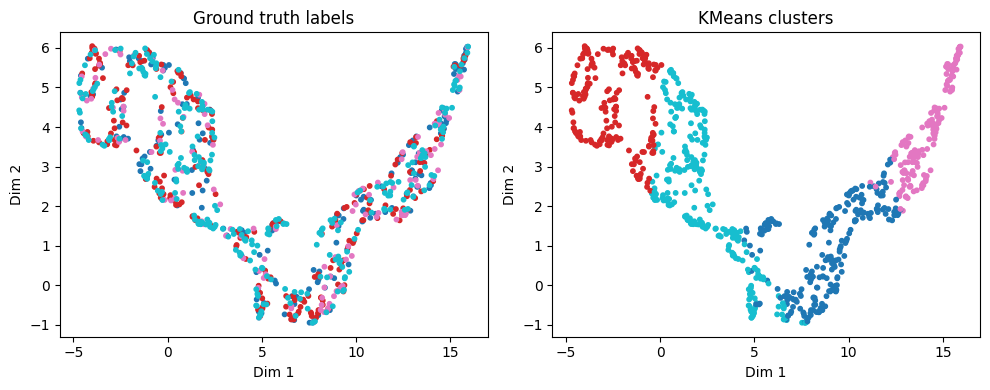

In [149]:
if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    if "X_feat" in globals():
        features = X_feat
    else:
        rocket = MiniRocket()
        features = rocket.fit_transform(X3d)

    if "clusters" not in globals():
        kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
        clusters = kmeans.fit_predict(features)

    if UMAP is not None:
        reducer = UMAP(n_components=2, random_state=0)
        emb = reducer.fit_transform(features)
    else:
        emb = PCA(n_components=2).fit_transform(features)

    label_to_id = {lab: idx for idx, lab in enumerate(sorted(set(y)))}
    y_ids = np.array([label_to_id[lab] for lab in y])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(emb[:, 0], emb[:, 1], c=y_ids, cmap="tab10", s=10)
    axes[0].set_title("Ground truth labels")
    axes[1].scatter(emb[:, 0], emb[:, 1], c=clusters, cmap="tab10", s=10)
    axes[1].set_title("KMeans clusters")
    for ax in axes:
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    plt.tight_layout()
    save_fig("embedding_labels_vs_clusters.png")
    plt.show()


## 10) Record-level clustering (no label leakage)

Aggregating beat features per recording can be more stable than beat-level clustering.
This is the preferred unsupervised target when sampling is low.


In [150]:
if MiniRocket is None or len(X) == 0:
    print("MiniRocket not available or no beats extracted.")
else:
    X3d = X[:, np.newaxis, :]
    if "X_feat" in globals():
        features = X_feat
    else:
        rocket = MiniRocket()
        features = rocket.fit_transform(X3d)
    if hasattr(features, "to_numpy"):
        features = features.to_numpy()

    record_features = []
    record_labels = []
    record_names = []
    for rec in records:
        idx = np.where(group_ids == rec.group_id)[0]
        if len(idx) == 0:
            continue
        record_features.append(features[idx].mean(axis=0))
        record_labels.append(rec.label)
        record_names.append(rec.group_id)

    record_features = np.vstack(record_features)
    record_labels = np.array(record_labels)

    kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
    record_clusters = kmeans.fit_predict(record_features)
    evaluate_clustering(record_labels, record_clusters, label="Record-level KMeans")


Record-level KMeans ARI: -0.074 | NMI: 0.155
Record-level KMeans best alignment accuracy: 0.389
Record-level KMeans mapping (cluster -> label): {0: 'control', 3: 'doxo', 1: 'empa', 2: 'empa_doxo'}


## 10b) Record-level features (band power + PSD HR + HRV proxy)
This uses record-level features that remain meaningful at 60 fps.
It avoids beat-shape reliance and is preferred for clustering here.


In [151]:
def band_power(signal: np.ndarray, fs: float, band: tuple[float, float]) -> float:
    f, pxx = welch(signal, fs=fs, nperseg=min(2048, len(signal)))
    low, high = band
    mask = (f >= low) & (f <= high)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pxx[mask], f[mask]))


record_features = []
record_labels = []

for rec in records:
    resp_band = resp_band_from_target()
    resp_power = band_power(rec.signal, rec.fs, resp_band)
    heart_power = band_power(rec.signal, rec.fs, HEART_BAND_HZ)
    hr_psd = estimate_hr_psd(rec.signal, rec.fs, HEART_BAND_HZ, SEPARATION_METHOD)

    _, heart = separate_components(rec.signal, rec.fs, method=SEPARATION_METHOD)
    peaks, _ = detect_beats(heart, rec.fs)
    if len(peaks) >= 3:
        intervals = np.diff(peaks) / rec.fs
        hrv_proxy = float(np.std(intervals))
    else:
        hrv_proxy = 0.0

    record_features.append([resp_power, heart_power, hr_psd or 0.0, hrv_proxy])
    record_labels.append(rec.label)

record_features = np.array(record_features)
record_labels = np.array(record_labels)

kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
rec_clusters = kmeans.fit_predict(record_features)
evaluate_clustering(record_labels, rec_clusters, label="Record features KMeans")


Record features KMeans ARI: 0.074 | NMI: 0.308
Record features KMeans best alignment accuracy: 0.500
Record features KMeans mapping (cluster -> label): {3: 'control', 2: 'doxo', 0: 'empa', 1: 'empa_doxo'}
